In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import text_dataset_from_directory

In [2]:
### reading the data

In [8]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/aclImdb/')
GloVe_file = pathlib.Path('/home/antirrabia/Documents/DeepLearning-SETs/glove.6B/glove.6B.100d.txt')

In [6]:
tr_d = text_dataset_from_directory( w_dir / 'train' )
va_d = text_dataset_from_directory( w_dir / 'validation' )
te_d = text_dataset_from_directory( w_dir / 'test' )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [11]:
# getting sequence of int
text_vectorization = layers.TextVectorization(
    max_tokens=20000,
    output_mode='int',
    output_sequence_length=600
)

In [12]:
text_only = tr_d.map( lambda x, y: x )

text_vectorization.adapt( text_only )

In [18]:
tr_d_pre = tr_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE )
va_d_pre = va_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE )
te_d_pre = te_d.map( lambda x, y: ( text_vectorization(x), y), num_parallel_calls=tf.data.AUTOTUNE )

In [19]:
tr_d_pre = tr_d_pre.prefetch( buffer_size=tf.data.AUTOTUNE )
va_d_pre = va_d_pre.prefetch( buffer_size=tf.data.AUTOTUNE )
te_d_pre = te_d_pre.prefetch( buffer_size=tf.data.AUTOTUNE )

### Getting the GloVe word-embeddings matrix

In [10]:
embedding_index = {}
with open(GloVe_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs
        
print(f"Found {len(embedding_index)} word vectors.")

Found 400000 word vectors.


In [13]:
embedding_dim = 100
max_tokens = 20000

vocabulary = text_vectorization.get_vocabulary()

word_index = dict( zip( vocabulary, range( len( vocabulary ) ) ) )

embedding_matrix = np.zeros( (max_tokens, embedding_dim) )

for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embedding_index.get( word )
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

### The model

In [16]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [17]:
with strategy.scope():
    inputs = keras.Input(shape=(None,), dtype='int64')
    
    embedded = embedding_layer(inputs)
    
    x = layers.Bidirectional( layers.LSTM(32) )(embedded)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'pretrained_embedding.keras',
        save_best_only=True
    ),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d_pre.cache(),
    epochs=7,
    validation_data=va_d_pre.cache(),
    callbacks=callbacks
)

Epoch 1/7
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task

In [23]:
model_test = keras.models.load_model('pretrained_embedding.keras')

print(f"Accuracy: { model_test.evaluate(te_d_pre)[1]:.3f}")

782/782 [==============================] - 27s 31ms/step - loss: 0.3328 - accuracy: 0.8564
Accuracy: 0.856


### Ploting The Training

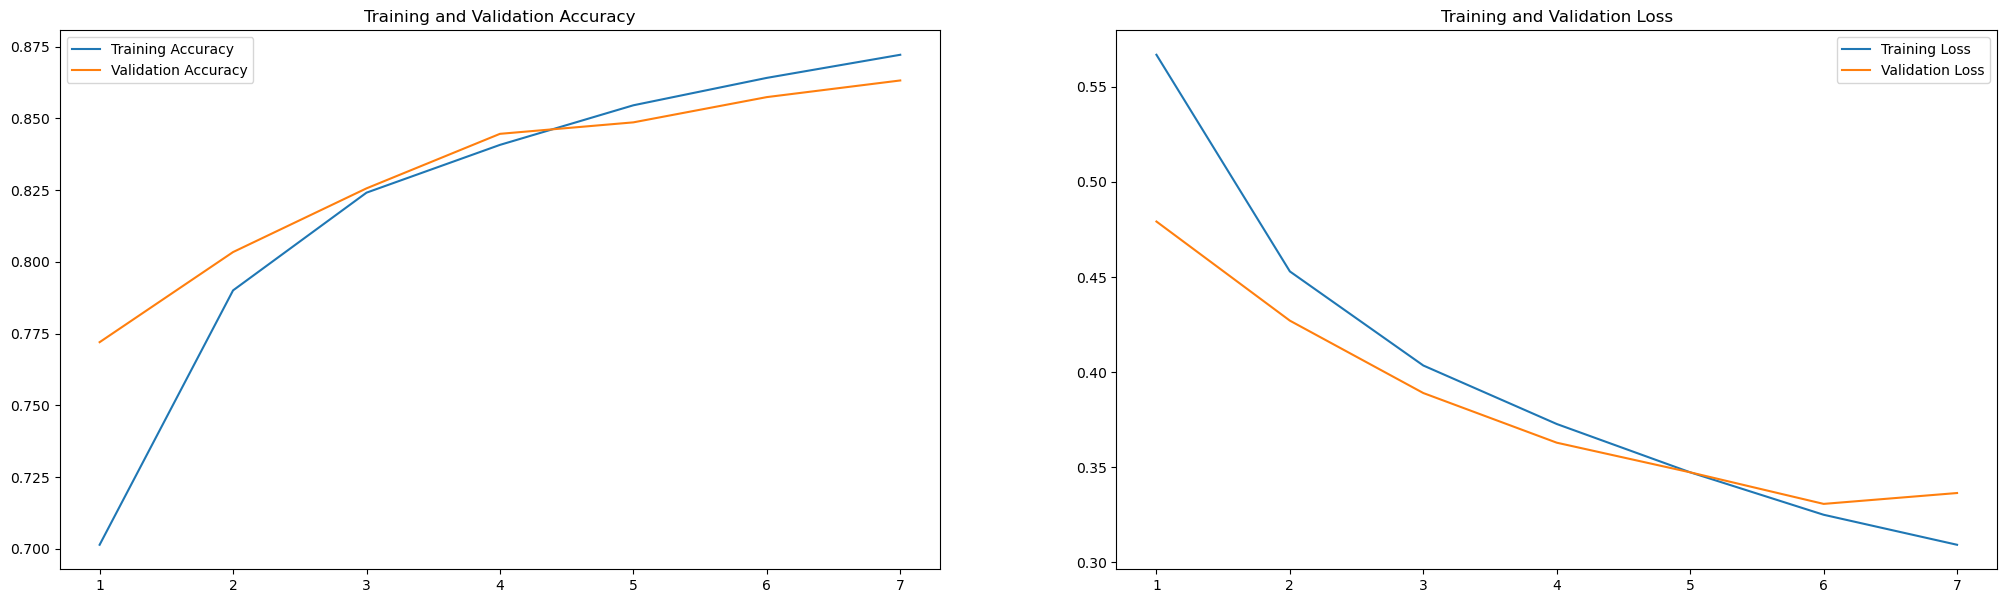

In [22]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range( 1, len( accuracy ) + 1 )

fig, ax = plt.subplots( ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_acc, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend();

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend();